In this project I'll show how to make portfolio optimisation for the given assets. Assets could vary from single stocks to ETFs or mutual fund data.

I'll feed the program with the returns of given assets and it will give me the weights of the optimal portfolio using the 'Efficient Frontier' approach. First let's start with some information on the portfolio optimization techniques and the one I'll be using for this project.

Portfolio optimization is the process of selecting a combination of investments that maximize returns for a given level of risk or minimize risk for a given level of return. It is a central component of modern finance and is used to help investors make informed decisions about how to allocate their assets.

There are several best practice techniques for portfolio optimization that have been developed over the years by financial experts and academics. Some of the most widely used techniques include:

Markowitz Portfolio Optimization: Developed by Harry Markowitz in the 1950s, this is one of the earliest and most widely used techniques for portfolio optimization. It involves using statistical methods to determine the optimal combination of assets that provide the highest expected return for a given level of risk, or the lowest risk for a given level of return.

Black-Litterman Model: This model is an extension of the Markowitz model and takes into account the views and opinions of the investor when determining the optimal portfolio. It allows the investor to specify their own expected returns for different assets, which can be used to adjust the optimal portfolio.

Mean-Variance Optimization: This technique is similar to the Markowitz model and involves optimizing the portfolio by minimizing the variance of the portfolio's returns while also maximizing expected return.

Risk Parity Portfolio: This portfolio construction technique seeks to allocate assets such that each asset contributes equally to the portfolio's overall risk. This can result in a more balanced and diversified portfolio.

Maximum Diversification Portfolio: This portfolio construction technique seeks to maximize the diversification of the portfolio by maximizing the number of uncorrelated assets in the portfolio.

Minimum Variance Portfolio: This portfolio construction technique seeks to minimize the portfolio's overall risk by selecting the combination of assets that have the lowest expected risk.

In this project I'll be using Markowitz Portfolio Optimization and using the 'Efficient Frontier' approach.

The steps one should go over when optimizing a portfolio with this method are as the following:

-Estimation of expected returns: The expected returns for each asset in the portfolio are estimated based on historical data or other sources of information.

-Calculation of covariance matrix: The covariance between the returns of different assets is calculated to determine the risk associated with holding a portfolio of assets.

-Construction of the efficient frontier: The efficient frontier is constructed by plotting the expected returns and standard deviations of all possible portfolios and selecting the portfolios that offer the highest expected return for a given level of risk, or the lowest risk for a given level of return.

-Portfolio selection: The portfolio that lies on the efficient frontier that provides the highest expected return for a given level of risk, or the lowest risk for a given level of return, is selected as the optimal portfolio.

A note on assumptions: It is important to note that Markowitz Portfolio Optimization makes certain assumptions, such as the normality of asset returns and the constancy of covariances over time. While these assumptions are reasonable in many cases, they may not always hold, so it is important to be aware of the limitations of the model when using it for portfolio optimization.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the data into a pandas DataFrame
df = pd.read_excel('annual_returns.xlsx', sheet_name='Sheet3', index_col=0)
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
df[numeric_cols.columns] = numeric_cols / 100

# Calculate mean and variance of returns for each asset
mean_returns = df.mean()
cov_matrix = df.cov()

# print('Mean: \n', mean_returns)
# print('Cov_matrix: \n', cov_matrix)

# Number of assets
num_assets = len(mean_returns)

# Define objective function for Sharpe ratio optimization
def sharpe_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Define objective function for Sortino ratio optimization
def sortino_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    
    # Calculate downside deviation
    downside_returns = df[df < 0].fillna(0)
    downside_deviation = np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov(), weights)))
    
    # Sortino ratio
    return -portfolio_return / downside_deviation

# Define constraint that weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define bounds for weights (between 0 and 1)
bounds = tuple((0, 1) for i in range(num_assets))

# Define initial guess for weights (equal weights)
init_guess = [1/num_assets] * num_assets

# Optimize portfolio based on Sharpe ratio
sharpe_portfolio = minimize(sharpe_ratio, init_guess, method='SLSQP',
                            constraints=constraints, bounds=bounds)

# Optimize portfolio based on Sortino ratio
sortino_portfolio = minimize(sortino_ratio, init_guess, method='SLSQP',
                             constraints=constraints, bounds=bounds)

# Extract weights of Sharpe ratio optimized portfolio
sharpe_weights = sharpe_portfolio.x
sharpe_weights_dict = dict(zip(df.columns, sharpe_weights))

# Extract weights of Sortino ratio optimized portfolio
sortino_weights = sortino_portfolio.x
sortino_weights_dict = dict(zip(df.columns, sortino_weights))

# Print Sharpe ratio optimized portfolio weights
print("Efficient Frontier Portfolio using Sharpe Ratio")
print('Weights are as follows:')
for asset, weight in sharpe_weights_dict.items():
    print(f"{asset}: {weight:.2f}")

# Print Sortino ratio optimized portfolio weights
print("\nEfficient Frontier Portfolio using Sortino Ratio")
print('Weights are as follows:')
for asset, weight in sortino_weights_dict.items():
    print(f"{asset}: {weight:.2f}")

# Calculate returns and volatility of Sharpe ratio optimized portfolio
sharpe_portfolio_return = np.dot(sharpe_weights, mean_returns)
sharpe_portfolio_return_annual = (1 + sharpe_portfolio_return)**12 - 1 
sharpe_portfolio_volatility = np.sqrt(np.dot(sharpe_weights.T, np.dot(cov_matrix, sharpe_weights)))
sharpe_portfolio_volatility_annual = sharpe_portfolio_volatility * math.sqrt(12)

# Calculate returns and volatility of Sortino ratio optimized portfolio
sortino_portfolio_return = np.dot(sortino_weights, mean_returns)
sortino_portfolio_return_annual = (1 + sortino_portfolio_return)**12 - 1 
sortino_downside_returns = df[df < 0].fillna(0)
sortino_portfolio_volatility = np.sqrt(np.dot(sortino_weights.T, np.dot(sortino_downside_returns.cov(), sortino_weights)))
sortino_portfolio_volatility_annual = sortino_portfolio_volatility * math.sqrt(12)

# Print results for Sharpe ratio optimized portfolio
print(f'\nSharpe Ratio Optimized Portfolio')
print(f'Expected return: {sharpe_portfolio_return_annual:.2f}')
print(f'Volatility: {sharpe_portfolio_volatility_annual:.2f}')

# Print results for Sortino ratio optimized portfolio
print(f'\nSortino Ratio Optimized Portfolio')
print(f'Expected return: {sortino_portfolio_return_annual:.2f}')
print(f'Volatility: {sortino_portfolio_volatility_annual:.2f}')



# Plot efficient frontier for Sharpe ratio optimized portfolio
portfolio_returns_sharpe = []
portfolio_volatilities_sharpe = []
for i in range(2000):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)
    portfolio_returns_sharpe.append((1+np.dot(weights.T, mean_returns))**12-1)
    portfolio_volatilities_sharpe.append(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * math.sqrt(12))
portfolio_returns_sharpe = np.array(portfolio_returns_sharpe)
portfolio_volatilities_sharpe = np.array(portfolio_volatilities_sharpe)

plt.figure(figsize=(5, 3))
plt.scatter(portfolio_volatilities_sharpe, portfolio_returns_sharpe, marker='.', color='blue', alpha=0.5, label='Random Portfolios')
plt.scatter(sharpe_portfolio_volatility_annual, sharpe_portfolio_return_annual, color='red', marker='*', s=100, label='Optimal Portfolio')
plt.title('Efficient Frontier (Sharpe Ratio)')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

# Plot efficient frontier for Sortino ratio optimized portfolio
portfolio_returns_sortino = []
portfolio_volatilities_sortino = []
for i in range(2000):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)
    portfolio_returns_sortino.append((1+np.dot(weights.T, mean_returns))**12-1)
    downside_returns = df[df < 0].fillna(0)
    portfolio_volatilities_sortino.append(np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov(), weights)))* math.sqrt(12))
portfolio_returns_sortino = np.array(portfolio_returns_sortino)
portfolio_volatilities_sortino = np.array(portfolio_volatilities_sortino)

plt.figure(figsize=(5, 3))
plt.scatter(portfolio_volatilities_sortino, portfolio_returns_sortino, marker='.', color='green', alpha=0.5, label='Random Portfolios')
plt.scatter(sortino_portfolio_volatility_annual, sortino_portfolio_return_annual, color='orange', marker='*', s=100, label='Optimal Portfolio')
plt.title('Efficient Frontier (Sortino Ratio)')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.show()


KeyboardInterrupt: 

Here is a version to give tickers to get data from Yahoo Finance instead of giving monthly returns in an excel file...

[*********************100%***********************]  6 of 6 completed


Efficient Frontier Portfolio using Sharpe Ratio
DIA: 0.05
MARA: 0.09
QQQ: 0.71
RIOT: 0.05
SPY: 0.05
TLT: 0.05

Efficient Frontier Portfolio using Sortino Ratio
DIA: 0.05
MARA: 0.75
QQQ: 0.05
RIOT: 0.05
SPY: 0.05
TLT: 0.05

Sharpe Ratio Optimized Portfolio
Expected return: 0.44
Volatility: 0.35

Sortino Ratio Optimized Portfolio
Expected return: 2.48
Volatility: 0.45


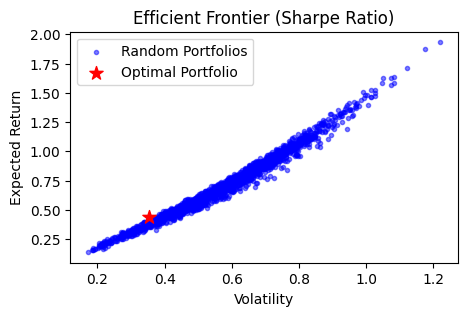

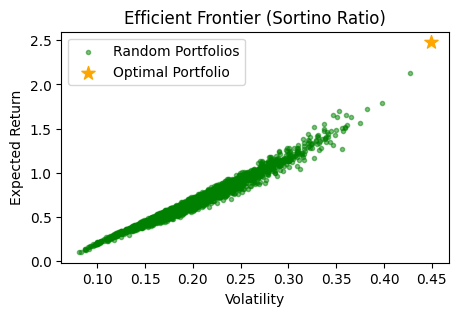

In [34]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta

# Define the tickers for your portfolio
#tickers = ['IUIS.L','EEM','IUSP.L','IDTL.L','NFE','XOM']
#tickers = ['IUIS.L','EEM','IUSP.L','IDTL.L','NFE','XOM','FTAI']
tickers = [
    'NFE', 'FOA', 'MPW', 'ABCB', 'GE', 'FN', 'FTAI', 'PLTR', 'MU', 'MRK',
    'CI', 'AMD', 'INTC', 'ZTS', 'ET', 'BSX', 'MELI', 'AVGO', 'LLY', 'DE',
    'CAT', 'UBER', 'UNP', 'HON', 'RTX', 'BA', 'LMT', 'ADP', 'ETN', 'DOUG',
    'OC', 'SLB', 'XOM', 'HTLD', 'FWRD', 'PBI', 'LNG', 'GLNG', 'RIG', 'VAL'
]

#tickers = ['IUIS.L','EEM','IUSP.L','IDTL.L','NFE','XOM','FTAI','SISE.IS']
min_bound = 0.05
years = 5

# Function to get the last month's start date and go back 5 years
def get_x_year_range(years):
    lookback = years
    end_date = datetime.today().replace(day=1)  # Current month start
    start_date = end_date - timedelta(days=years*365)  # Go back 5 years (approximately)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

# Download historical data for the tickers (monthly returns)
def get_monthly_returns(tickers):
    start_date, end_date = get_x_year_range(years)
    data = yf.download(tickers, start=start_date, end=end_date, interval="1mo")['Adj Close']
    
    # Remove any tickers with missing data (NaN values)
    data = data.dropna(axis=1, how='any')  # Drop columns (tickers) with any NaN values
    
    returns = data.pct_change().dropna()  # Get percentage changes (monthly returns)
    return returns

df = get_monthly_returns(tickers)

# Check if any tickers were dropped due to missing data
missing_tickers = set(tickers) - set(df.columns)
if missing_tickers:
    print(f"The following tickers were removed due to insufficient data: {', '.join(missing_tickers)}")

# Check if we have enough tickers to proceed
if df.shape[1] == 0:
    raise ValueError("No valid tickers with sufficient data for the given time range.")

# Calculate mean and covariance of returns
mean_returns = df.mean()
corr_matrix = df.corr()
cov_matrix = df.cov()


# test matrices
# print("Mean Returns")
# print(mean_returns)
# print("Corr Matrix")
# print(corr_matrix)
# print("Cov Matrix")
# print(cov_matrix)


# Number of assets
num_assets = len(mean_returns)

# Define objective function for Sharpe ratio optimization
def sharpe_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Define objective function for Sortino ratio optimization
def sortino_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    
    # Calculate downside deviation
    downside_returns = df[df < 0].fillna(0)
    downside_deviation = np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov(), weights)))
    
    # Sortino ratio
    return -portfolio_return / downside_deviation

# Define constraint that weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define bounds for weights (between 0 and 1)
bounds = tuple((min_bound, 1) for i in range(num_assets))

# Define initial guess for weights (equal weights)
init_guess = [1/num_assets] * num_assets

# Optimize portfolio based on Sharpe ratio
sharpe_portfolio = minimize(sharpe_ratio, init_guess, method='SLSQP',
                            constraints=constraints, bounds=bounds)

# Optimize portfolio based on Sortino ratio
sortino_portfolio = minimize(sortino_ratio, init_guess, method='SLSQP',
                             constraints=constraints, bounds=bounds)

# Extract weights of Sharpe ratio optimized portfolio
sharpe_weights = sharpe_portfolio.x
sharpe_weights_dict = dict(zip(df.columns, sharpe_weights))

# Extract weights of Sortino ratio optimized portfolio
sortino_weights = sortino_portfolio.x
sortino_weights_dict = dict(zip(df.columns, sortino_weights))

# Print results
print("Efficient Frontier Portfolio using Sharpe Ratio")
for asset, weight in sharpe_weights_dict.items():
    print(f"{asset}: {weight:.2f}")

print("\nEfficient Frontier Portfolio using Sortino Ratio")
for asset, weight in sortino_weights_dict.items():
    print(f"{asset}: {weight:.2f}")

# Calculate returns and volatility of Sharpe ratio optimized portfolio
sharpe_portfolio_return = np.dot(sharpe_weights, mean_returns)
sharpe_portfolio_return_annual = (1 + sharpe_portfolio_return)**12 - 1 
sharpe_portfolio_volatility = np.sqrt(np.dot(sharpe_weights.T, np.dot(cov_matrix, sharpe_weights)))
sharpe_portfolio_volatility_annual = sharpe_portfolio_volatility * math.sqrt(12)

# Calculate returns and volatility of Sortino ratio optimized portfolio
sortino_portfolio_return = np.dot(sortino_weights, mean_returns)
sortino_portfolio_return_annual = (1 + sortino_portfolio_return)**12 - 1 
sortino_downside_returns = df[df < 0].fillna(0)
sortino_portfolio_volatility = np.sqrt(np.dot(sortino_weights.T, np.dot(sortino_downside_returns.cov(), sortino_weights)))
sortino_portfolio_volatility_annual = sortino_portfolio_volatility * math.sqrt(12)

# Print results for Sharpe ratio optimized portfolio
print(f'\nSharpe Ratio Optimized Portfolio')
print(f'Expected return: {sharpe_portfolio_return_annual:.2f}')
print(f'Volatility: {sharpe_portfolio_volatility_annual:.2f}')

# Print results for Sortino ratio optimized portfolio
print(f'\nSortino Ratio Optimized Portfolio')
print(f'Expected return: {sortino_portfolio_return_annual:.2f}')
print(f'Volatility: {sortino_portfolio_volatility_annual:.2f}')

# Plot efficient frontier for Sharpe ratio optimized portfolio
portfolio_returns_sharpe = []
portfolio_volatilities_sharpe = []
for i in range(2000):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)
    portfolio_returns_sharpe.append((1+np.dot(weights.T, mean_returns))**12-1)
    portfolio_volatilities_sharpe.append(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * math.sqrt(12))
portfolio_returns_sharpe = np.array(portfolio_returns_sharpe)
portfolio_volatilities_sharpe = np.array(portfolio_volatilities_sharpe)

plt.figure(figsize=(5, 3))
plt.scatter(portfolio_volatilities_sharpe, portfolio_returns_sharpe, marker='.', color='blue', alpha=0.5, label='Random Portfolios')
plt.scatter(sharpe_portfolio_volatility_annual, sharpe_portfolio_return_annual, color='red', marker='*', s=100, label='Optimal Portfolio')
plt.title('Efficient Frontier (Sharpe Ratio)')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

# Plot efficient frontier for Sortino ratio optimized portfolio
portfolio_returns_sortino = []
portfolio_volatilities_sortino = []
for i in range(2000):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)
    portfolio_returns_sortino.append((1+np.dot(weights.T, mean_returns))**12-1)
    downside_returns = df[df < 0].fillna(0)
    portfolio_volatilities_sortino.append(np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov(), weights)))* math.sqrt(12))
portfolio_returns_sortino = np.array(portfolio_returns_sortino)
portfolio_volatilities_sortino = np.array(portfolio_volatilities_sortino)

plt.figure(figsize=(5, 3))
plt.scatter(portfolio_volatilities_sortino, portfolio_returns_sortino, marker='.', color='green', alpha=0.5, label='Random Portfolios')
plt.scatter(sortino_portfolio_volatility_annual, sortino_portfolio_return_annual, color='orange', marker='*', s=100, label='Optimal Portfolio')
plt.title('Efficient Frontier (Sortino Ratio)')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.show()
